# Load Library

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import warnings

warnings.filterwarnings('ignore')

In [75]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, FJRMIA_attack, imputation_attack, whitebox_neuron_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [73]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 0.5,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in np.arange(-0.4, 0.05, 0.05)[:1].tolist()]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

[0, 1]
{0: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}, 1: {(0, 1): 6523, (0, 0): 1809, (1, 1): 5977, (1, 0): 10691}}


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


{0: {(0, 1): 4755, (0, 0): 3577, (1, 1): 7745, (1, 0): 8923}, 1: {(0, 1): 5345, (0, 0): 2988, (1, 1): 7155, (1, 0): 9512}}


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


In [132]:
experiments = { k:  MIAExperiment(name='Adult') for k in np.arange(0, 0.95, 0.05)[:1].tolist()}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][-1:]}

In [133]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Adult
Loaded classifier for experiment from file: Adult


In [104]:
experiment.sensitive_column = experiment.ds.ds.meta['sensitive_column']
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
experiment.sens_val_ground_truth = experiment.X_train[[f'{experiment.sensitive_column}_{experiment.ds.ds.meta["sensitive_positive"]}']].to_numpy().ravel()
experiment.sens_pred = sens_pred

Index(['fnlwgt', 'capitalgain', 'capitalloss', 'hoursperweek',
       'work_Federal-gov', 'work_Local-gov', 'work_Private',
       'work_Self-emp-inc', 'work_Self-emp-not-inc', 'work_State-gov',
       'work_Without-pay', 'education_edu1', 'education_edu2',
       'education_edu3', 'marital_Married', 'marital_Single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Female', 'sex_Male'],
      dtype='object')


In [113]:
correlation_vs_ang_diff = {}
subgroup_col_name = 'occupation'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
conditions = [{subgroup_col_name: i} for i in subgroup_vals] + [{}]
for condition in conditions:
    fcondition = f'{condition}'
    correlation_vs_ang_diff[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)

correlation_vs_ang_diff

{"{'occupation': 'Prof-specialty'}": {'CSMIA_attack_accuracy': 0.7566305962232124},
 "{'occupation': 'Other-service'}": {'CSMIA_attack_accuracy': 0.7815508021390374},
 "{'occupation': 'Adm-clerical'}": {'CSMIA_attack_accuracy': 0.8160651920838184},
 "{'occupation': 'Craft-repair'}": {'CSMIA_attack_accuracy': 0.5589929592489865},
 "{'occupation': 'Farming-fishing'}": {'CSMIA_attack_accuracy': 0.49437229437229435},
 "{'occupation': 'Machine-op-inspct'}": {'CSMIA_attack_accuracy': 0.6119402985074627},
 "{'occupation': 'Exec-managerial'}": {'CSMIA_attack_accuracy': 0.7339449541284404},
 "{'occupation': 'Priv-house-serv'}": {'CSMIA_attack_accuracy': 0.8391959798994975},
 "{'occupation': 'Sales'}": {'CSMIA_attack_accuracy': 0.7294285036755987},
 "{'occupation': 'Transport-moving'}": {'CSMIA_attack_accuracy': 0.5298759864712514},
 "{'occupation': 'Handlers-cleaners'}": {'CSMIA_attack_accuracy': 0.6884517766497462},
 "{'occupation': 'Protective-serv'}": {'CSMIA_attack_accuracy': 0.618610747051

In [127]:
correlation_vs_ang_diff = {}
subgroup_col_name = 'race'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
conditions = [{subgroup_col_name: i} for i in subgroup_vals] + [{}]
for condition in conditions:
    fcondition = f'{condition}'
    correlation_vs_ang_diff[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)

correlation_vs_ang_diff

{"{'race': 'White'}": {'CSMIA_attack_accuracy': 0.6916440801216368},
 "{'race': 'Black'}": {'CSMIA_attack_accuracy': 0.7798028084852107},
 "{'race': 'Asian-Pac-Islander'}": {'CSMIA_attack_accuracy': 0.6925403225806451},
 "{'race': 'Other'}": {'CSMIA_attack_accuracy': 0.6385964912280702},
 "{'race': 'Amer-Indian-Eskimo'}": {'CSMIA_attack_accuracy': 0.6947674418604651},
 '{}': {'CSMIA_attack_accuracy': 0.6996479473056613}}

In [128]:
correlation_vs_ang_diff = {}
conditions = [
    {'race': 'Black'},
    {'occupation': 'Armed-Forces'},
    {'race': 'Black', 'occupation': 'Armed-Forces'},
    {'education': 'edu3', 'occupation': 'Armed-Forces'},
    {'education': 'edu3', 'race': 'Black'},
    {'occupation': 'Adm-clerical', 'race': 'Black'},
]
for condition in conditions:
    fcondition = f'{condition}'
    correlation_vs_ang_diff[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)

correlation_vs_ang_diff

{"{'race': 'Black'}": {'CSMIA_attack_accuracy': 0.7798028084852107},
 "{'occupation': 'Armed-Forces'}": {'CSMIA_attack_accuracy': 0.8461538461538461},
 "{'race': 'Black', 'occupation': 'Armed-Forces'}": {'CSMIA_attack_accuracy': 1.0},
 "{'education': 'edu3', 'occupation': 'Armed-Forces'}": {'CSMIA_attack_accuracy': 1.0},
 "{'education': 'edu3', 'race': 'Black'}": {'CSMIA_attack_accuracy': 0.7989203778677463},
 "{'occupation': 'Adm-clerical', 'race': 'Black'}": {'CSMIA_attack_accuracy': 0.8706293706293706}}

In [134]:
X_train, X_test, y_train, y_test = experiment.X_train, experiment.X_test, experiment.y_tr.ravel(), experiment.y_te.ravel()

In [135]:
X_train.columns

Index(['fnlwgt', 'capitalgain', 'capitalloss', 'hoursperweek',
       'work_Federal-gov', 'work_Local-gov', 'work_Private',
       'work_Self-emp-inc', 'work_Self-emp-not-inc', 'work_State-gov',
       'work_Without-pay', 'education_edu1', 'education_edu2',
       'education_edu3', 'marital_Married', 'marital_Single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Female', 'sex_Male'],
      dtype='object')

In [152]:
experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta) 

Index(['fnlwgt', 'capitalgain', 'capitalloss', 'hoursperweek',
       'work_Federal-gov', 'work_Local-gov', 'work_Private',
       'work_Self-emp-inc', 'work_Self-emp-not-inc', 'work_State-gov',
       'work_Without-pay', 'education_edu1', 'education_edu2',
       'education_edu3', 'marital_Married', 'marital_Single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Female', 'sex_Male'],
      dtype='object')


In [157]:
male_indices = np.where(X_train[f'sex_Male'].ravel())[0]
female_indices = np.where(X_train[f'sex_Female'].ravel())[0]
experiment.sens_val_ground_truth = X_train[f'{experiment.ds.ds.meta["sensitive_column"]}_Single'].ravel() 

correct_male_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0], male_indices)
incorrect_male_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] != experiment.sens_pred_CSMIA[:])[0], male_indices)

correct_female_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0], female_indices)
incorrect_female_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] != experiment.sens_pred_CSMIA[:])[0], female_indices)

In [161]:
correct_male_indices

array([    0,     1,     2, ..., 35216, 35218, 35220])

In [158]:
confidence_scores = np.max(experiment.clf.predict_proba(X_train), axis=1)

In [ ]:
from seaborn import di

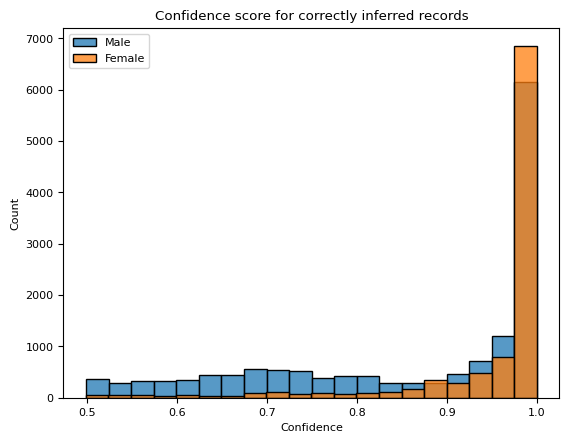

In [171]:
sns.histplot(confidence_scores[correct_male_indices], bins=20, label='Male')
sns.histplot(confidence_scores[correct_female_indices], bins=20, label='Female')
plt.xlabel('Confidence')
plt.title('Confidence score for correctly inferred records')
plt.legend()

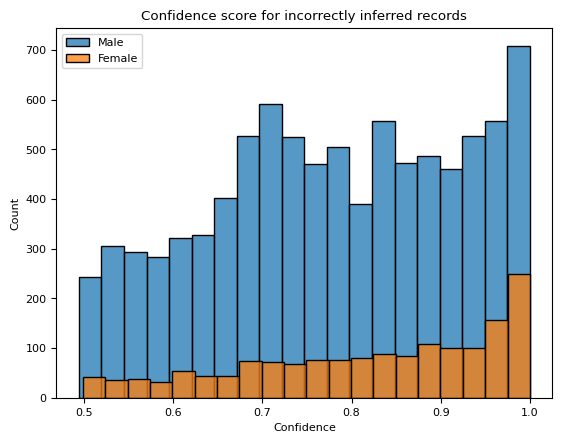

In [172]:
sns.histplot(confidence_scores[incorrect_male_indices], bins=20, label='Male')
sns.histplot(confidence_scores[incorrect_female_indices], bins=20, label='Female')
plt.xlabel('Confidence')
plt.title('Confidence score for incorrectly inferred records')
plt.legend()

Text(0.5, 1.0, 'Confidence of all male records')

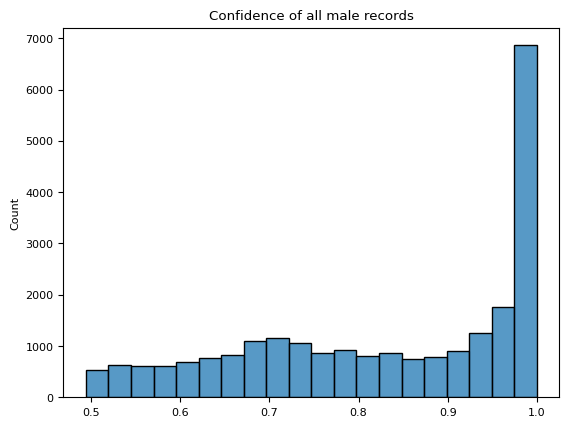

In [173]:
sns.histplot(confidence_scores[male_indices], bins=20)
plt.title('Confidence of all male records')

Text(0.5, 1.0, 'Confidence of all female records')

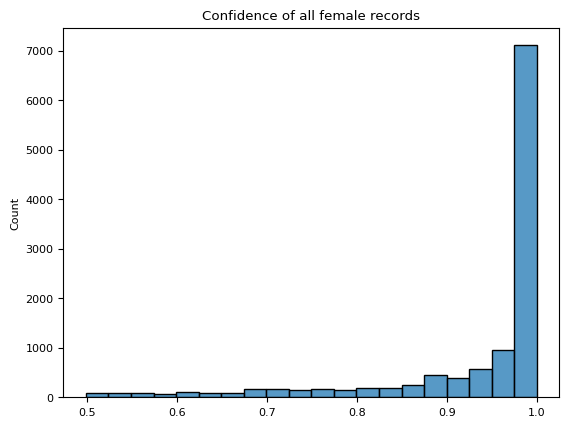

In [174]:
sns.histplot(confidence_scores[female_indices], bins=20)
plt.title('Confidence of all female records')

In [175]:
subgroup_column = 'race'
subgroup_values = ['White', 'Black']

group_1_indices = np.where(X_train[f'{subgroup_column}_{subgroup_values[0]}'].ravel())[0]
group_2_indices = np.where(X_train[f'{subgroup_column}_{subgroup_values[1]}'].ravel())[0]
experiment.sens_val_ground_truth = X_train[f'{experiment.ds.ds.meta["sensitive_column"]}_Single'].ravel() 

correct_group_1_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0], group_1_indices)
incorrect_group_1_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] != experiment.sens_pred_CSMIA[:])[0], group_1_indices)

correct_group_2_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0], group_2_indices)
incorrect_group_2_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] != experiment.sens_pred_CSMIA[:])[0], group_2_indices)

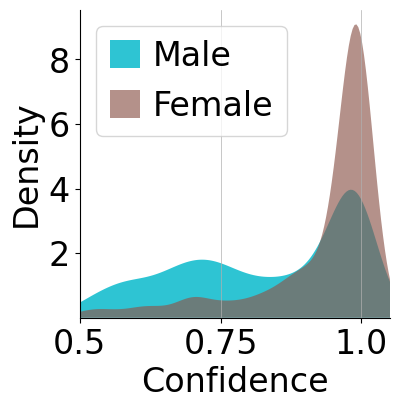

In [223]:
fig, ax = plt.subplots(figsize=(4,4))
sns.kdeplot(confidence_scores[male_indices[:1000]], label='Male', fill=True, edgecolor='none', color='#17becf', alpha=0.9)
sns.kdeplot(confidence_scores[female_indices[:1000]], fill=True, label='Female', edgecolor='none', color='#8c564b', alpha=0.65)
plt.xlabel('Confidence', fontsize=24, fontweight='regular')
plt.ylabel('Density', fontsize=24, fontweight='regular')
plt.yticks([2, 4, 6, 8],fontsize=24)
ax.set_xlim(0.5, 1.05)
ax.set_xticks(np.arange(0.5, 1.05, 0.25))
ax.set_xticklabels([i for i in np.arange(0.5, 1.05, 0.25)], fontsize=24, fontweight='regular')
plt.grid(True, linewidth=0.5, axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Confidence score for correctly inferred records')
plt.legend(fontsize=24, loc='upper left', handlelength=0.9, handleheight=0.9, handletextpad=0.4)

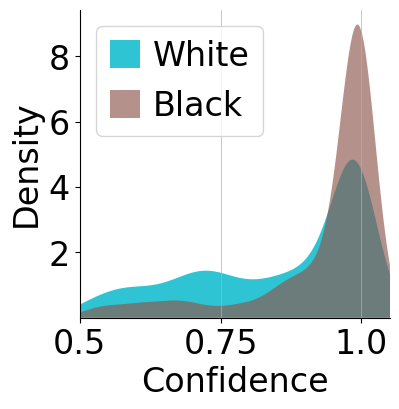

In [224]:
fig, ax = plt.subplots(figsize=(4,4))
sns.kdeplot(confidence_scores[group_1_indices[:1000]], label=subgroup_values[0], fill=True, edgecolor='none', color='#17becf', alpha=0.9)
sns.kdeplot(confidence_scores[group_2_indices[:1000]], fill=True, label=subgroup_values[1], edgecolor='none', color='#8c564b', alpha=0.65)
plt.xlabel('Confidence', fontsize=24, fontweight='regular')
plt.ylabel('Density', fontsize=24, fontweight='regular')
plt.yticks([2, 4, 6, 8],fontsize=24)
ax.set_xlim(0.5, 1.05)
ax.set_xticks(np.arange(0.5, 1.05, 0.25))
ax.set_xticklabels([i for i in np.arange(0.5, 1.05, 0.25)], fontsize=24, fontweight='regular')
plt.grid(True, linewidth=0.5, axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.title('Confidence score for correctly inferred records')
plt.legend(fontsize=24, loc='upper left', handlelength=0.9, handleheight=0.9, handletextpad=0.4)

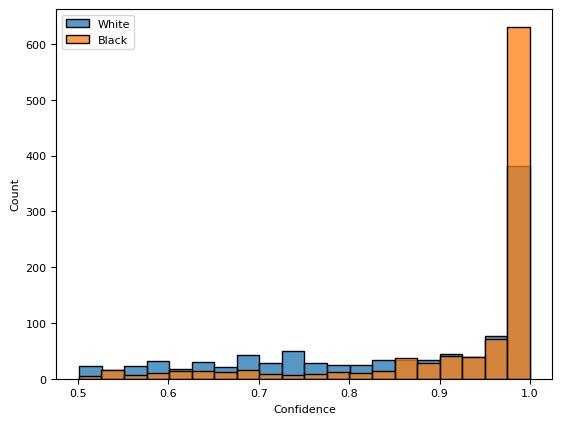

In [179]:
sns.histplot(confidence_scores[group_1_indices[:1000]], bins=20, label=subgroup_values[0])
sns.histplot(confidence_scores[group_2_indices[:1000]], bins=20, label=subgroup_values[1])
plt.xlabel('Confidence')
# plt.title('Confidence score for correctly inferred records')
plt.legend()

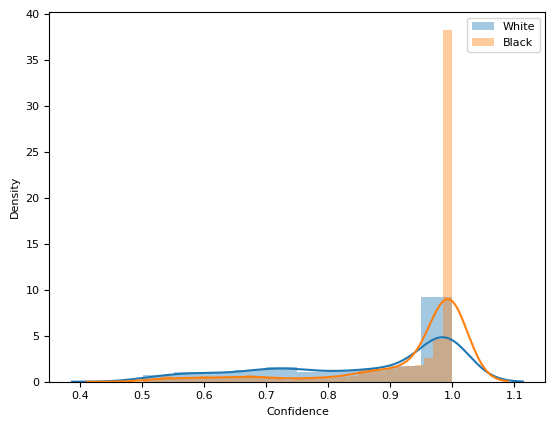

In [185]:
sns.distplot(confidence_scores[group_1_indices[:1000]], label=subgroup_values[0])
sns.distplot(confidence_scores[group_2_indices[:1000]], label=subgroup_values[1])
plt.xlabel('Confidence')
# plt.title('Confidence score for correctly inferred records')
plt.legend()

In [155]:
len(correct_male_indices)

14778

In [156]:
len(incorrect_male_indices)

8958

In [137]:
male_indices

(array([   1,    2,    3, ..., 9996, 9997, 9999]),)

In [95]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    # print(experiment.influence, experiment.correlation)
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta) 
    experiment.sens_val_ground_truth = X_test[f'{experiment.ds.ds.meta["sensitive_column"]}_{1}'].ravel() 
    case_2_incorrect_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] != experiment.sens_pred_CSMIA[:])[0], np.where(case_indices[2]))
    experiment.sens_pred_FJRMIA = FJRMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)  
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()
    experiment.CSMIA_performance = 100 * accuracy_score(experiment.sens_val_ground_truth[:], experiment.sens_pred_CSMIA[:])
    experiment.LOMIA_performance = 100 * accuracy_score(experiment.sens_val_ground_truth[case_2_incorrect_indices], experiment.sens_pred_LOMIA[case_2_incorrect_indices])
    experiment.FJRMIA_performance = 100 * accuracy_score(experiment.sens_val_ground_truth[case_2_incorrect_indices], experiment.sens_pred_FJRMIA[case_2_incorrect_indices])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- marital_0
- marital_1


In [87]:
100 * accuracy_score(experiment.sens_val_ground_truth[case_indices[1]], experiment.sens_pred_FJRMIA[case_indices[1]])

76.47563066372766

In [88]:
100 - experiment.LOMIA_performance

83.4676508247345

In [89]:
100 - experiment.FJRMIA_performance

50.598779844844465

In [90]:
mp = [X_test[f'{meta["sensitive_column"]}_{i}'].value_counts()[1] for i in range(len(meta["sensitive_values"]))]

In [91]:
mp

[25000, 25000]

In [67]:
X_train, X_test, y_train, y_test = experiment.X_train, experiment.X_test, experiment.y_tr, experiment.y_te.ravel()
meta = experiment.ds.ds.meta
model = experiment.clf
y_pred_ = np.argmax(model.predict_proba(X_test), axis=1)
y_preds = np.array([np.argmax(model.predict_proba(df), axis=1) for df in [X_train, X_test]]).T
sens_val_ground_truth = X_test[f'{meta["sensitive_column"]}_{1}'].ravel()

mp = [X_test[f'{meta["sensitive_column"]}_{i}'].value_counts()[1] for i in range(len(meta["sensitive_values"]))]
cm = np.array(confusion_matrix(y_test.ravel(), y_pred_))
cm = cm / cm.sum(axis=1, keepdims=True)
z = np.zeros((y_test.shape[0], cm.shape[1]))

# Populate the output array based on the conditions
z[y_test == 0] = cm[0]
z[y_test == 1] = cm[1]

row_indices = np.arange(y_preds.shape[0])[:, None]
c = z[row_indices, y_preds]

In [68]:
sens_pred_FJRMIA

array([0, 0, 0, ..., 0, 1, 1])

In [69]:
100 * accuracy_score(experiment.sens_val_ground_truth[case_2_incorrect_indices], sens_pred_FJRMIA[case_2_incorrect_indices])

51.39460039334883

In [97]:
case_2_incorrect_indices.shape[0]/50000

0.26554

In [64]:
cp

array([[0.08912 , 0.089121],
       [0.41088 , 0.08912 ],
       [0.41088 , 0.08912 ],
       ...,
       [0.42282 , 0.422821],
       [0.07718 , 0.42282 ],
       [0.422821, 0.42282 ]])

In [62]:
c * mp

array([[0.08912, 0.08912],
       [0.41088, 0.08912],
       [0.41088, 0.08912],
       ...,
       [0.42282, 0.42282],
       [0.07718, 0.42282],
       [0.42282, 0.42282]])

In [47]:
z

array([[20544.,  4456.],
       [20544.,  4456.],
       [20544.,  4456.],
       ...,
       [ 3859., 21141.],
       [ 3859., 21141.],
       [ 3859., 21141.]])

In [41]:
experiment.y_te_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [42]:
cm

array([[20544,  4456],
       [ 3859, 21141]])

In [39]:
np.cross(y_preds, cm)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (50000,) and arg 1 with shape (2,).

In [37]:
cm

array([[20544,  4456],
       [ 3859, 21141]])

In [28]:
experiment.LOMIA_performance

17.83479349186483

In [21]:
case_2_incorrect_indices = np.intersect1d(np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0], np.where(case_indices[2]))

In [22]:
case_indices[2]

array([False, False, False, ...,  True,  True,  True])

In [13]:
np.where(experiment.sens_val_ground_truth[:] == experiment.sens_pred_CSMIA[:])[0]

array([    1,     5,     7, ..., 49946, 49959, 49987])

In [20]:
case_2_correct_indices.shape

(24344,)

In [30]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment)
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf)
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [39]:
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    experiment.sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)   
    experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
    experiment.imputation_results = imputation_attack(experiment, subgroup_column='ETHNICITY')
    experiment.wb_neuron_results = whitebox_neuron_attack(experiment, experiment.clf, subgroup_column='ETHNICITY')
    experiment.sens_val_ground_truth = experiment.X_test[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()


In [31]:
def false_positive_rate(x, y):
    tp, fn, fp, tn = confusion_matrix(x, y).ravel()
    return round(fp / (fp + tn), 4)

eval_func = {
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'accuracy': accuracy_score,
    'fpr': false_positive_rate
}

metrics = ['accuracy', 'precision', 'recall', 'fpr', 'f1']

In [32]:
performance_dict = {}
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [74]:
performance_dict_texas = {}
for experiment_key in experiments_texas:
    experiment = experiments_texas[experiment_key]
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_test, experiment.y_te, {})
    performance_dict_texas[correlation] = {}
    indices = get_indices_by_group_condition(experiment.X_train, {})
    performance_dict_texas[correlation]['CSMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_CSMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['LOMIA_results'] = {metric: 100 * eval_func[metric](experiment.sens_val_ground_truth[indices], experiment.sens_pred_LOMIA[indices]) for metric in metrics}
    performance_dict_texas[correlation]['imputation_results'] = experiment.imputation_results
    performance_dict_texas[correlation]['wb_neuron_results'] = experiment.wb_neuron_results

In [81]:
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 15

def plot_result(performance_dict, metric='accuracy'):
    attacks = ['CSMIA', 'LOMIA', 'imputation', 'wb_neuron']
    attack_names = attacks[:2] + ['Imputation', 'NeuronIMP']
    metric_name_dict = {'accuracy': 'Attack Accuracy', 'f1': 'F1 Score'}
    performance_dict_metric = {corr: {f'{attack}_results': performance_dict[corr][f'{attack}_results'][metric] for attack in attacks} for corr in performance_dict}

    df = pd.DataFrame.from_dict(performance_dict_metric, orient='index')
    fig, ax = plt.subplots(figsize=(6, 4.5))
    line_styles = ['-', '--', '-.', ':']
    colors = ['#000000', '#4D4D4D', '#7F7F7F', '#BFBFBF']  # Different shades of black/gray
    markers = ['o', 's', '^', 'd']  # Circle, square, triangle up, diamond
    for i, attack in enumerate(attacks):
        plt.plot(df.index, df[f'{attack}_results'], label=attack_names[i], marker=markers[i], linestyle=line_styles[i], color=colors[i], markersize=5)

    x_ticks = np.arange(df.index.min(), df.index.max() + 0., 0.15).round(2).tolist()
    plt.xticks(x_ticks)
    plt.legend()
    plt.xlabel('Correlation')
    plt.ylabel(metric_name_dict[metric])
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    # plt.plot(df.index, df['LOMIA_attack_accuracy'], label='LOMIA', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))
    # plt.plot(df.index, df['imputation_attack_accuracy'], label='Imputation', marker=markers.pop(), color=colors.pop(), line_kws=dict(linewidth=0.5))

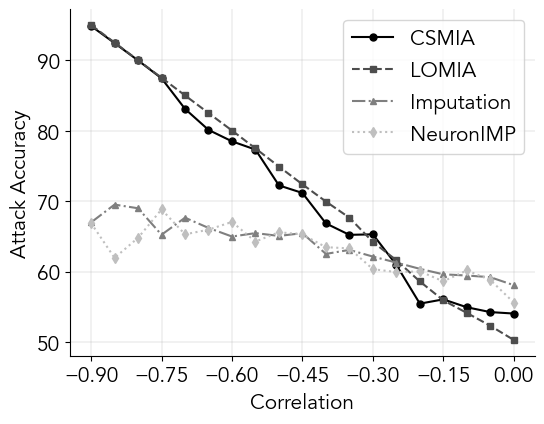

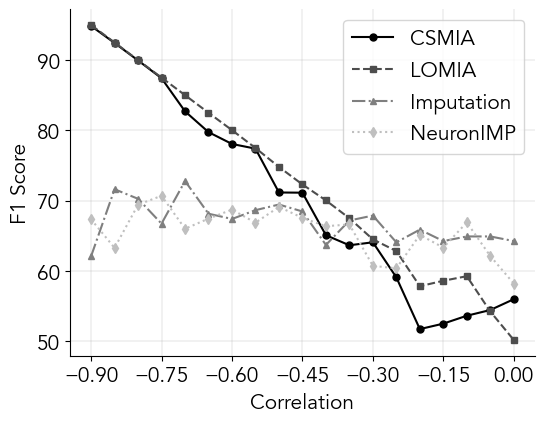

In [82]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict, metric=metric)

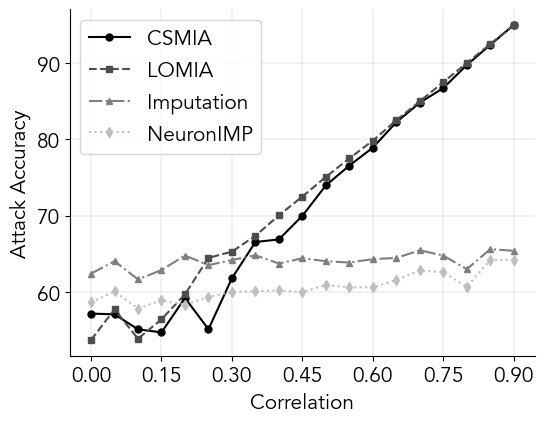

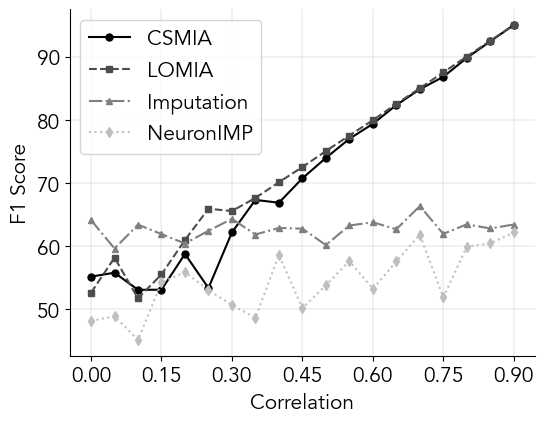

In [83]:
for metric in ['accuracy', 'f1']:
    plot_result(performance_dict_texas, metric=metric)